In [1]:
!pip install tensorflow_addons
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 20.5 MB/s 


In [6]:
mitbih_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/9063/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/9063/mitbih_train.csv", header=None)

mitbih_train[187]=mitbih_train[187].astype(int)
distributation=mitbih_train[187].value_counts()
print(distributation)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


Text(0.5, 1.0, 'Distribution of MIT-BIH dataset')

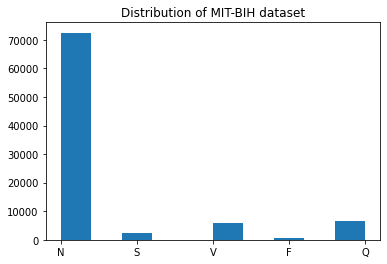

In [7]:
mitbih_train_labels = mitbih_train.iloc[:,-1].replace({0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'})
plt.hist(mitbih_train_labels)
plt.title("Distribution of MIT-BIH dataset")



Text(0.5, 1.0, 'MIT-BIH Dataset example')

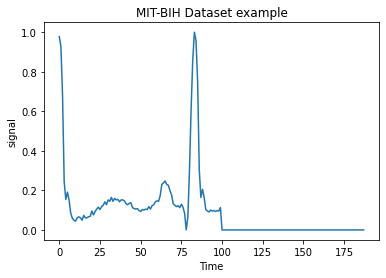

In [5]:
plt.plot(mitbih_train.iloc[0,:])
plt.xlabel('Time')
plt.ylabel('signal')
plt.title("MIT-BIH Dataset example")

In [8]:
ptbdb_abnormal = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/9063/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/9063/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

ptbdb[187]=ptbdb[187].astype(int)
distributation=ptbdb[187].value_counts()
print(distributation)

1    10506
0     4046
Name: 187, dtype: int64


Text(0.5, 1.0, 'Distribution of the PTB Database')

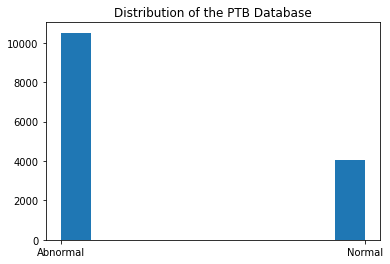

In [9]:
ptbdb_labels = ptbdb.iloc[:,-1].replace({0:'Normal',1:'Abnormal'})
plt.hist(ptbdb_labels)
plt.title("Distribution of the PTB Database")

Text(0.5, 1.0, 'PTB ECG Database example')

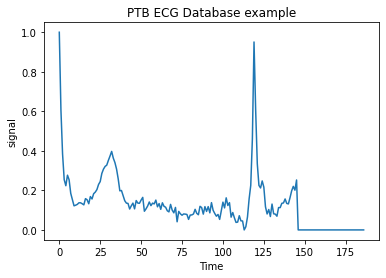

In [8]:
plt.plot(ptbdb.iloc[1,:-1])
plt.xlabel('Time')
plt.ylabel('signal')
plt.title("PTB ECG Database example")

In [10]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [11]:
def pretty_plot(history, field):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))
  g = lambda x: np.argmin(x)
  best_index = g(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    return out
  
  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = keras.layers.BatchNormalization()(X)
  X = keras.layers.ReLU()(X)
  X = keras.layers.MaxPool1D(5, 2)(X)
    
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)

  X = keras.layers.AveragePooling1D(5, 2)(X)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [15]:
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=18)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=18)

X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

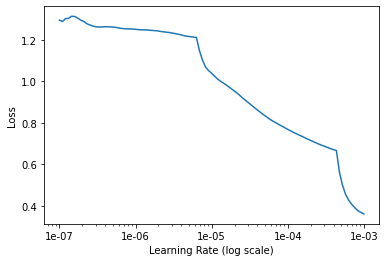

In [22]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [23]:

N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: 1 / (2.0 ** (x - 1)))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="ptbd_weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
91/91 [==============================] - 8s 30ms/step - loss: 0.3725 - accuracy: 0.8221 - val_loss: 0.6992 - val_accuracy: 0.5086
Epoch 2/75
91/91 [==============================] - 2s 20ms/step - loss: 0.1482 - accuracy: 0.9424 - val_loss: 0.8850 - val_accuracy: 0.7395
Epoch 3/75
91/91 [==============================] - 2s 20ms/step - loss: 0.0630 - accuracy: 0.9770 - val_loss: 0.7845 - val_accuracy: 0.5794
Epoch 4/75
91/91 [==============================] - 2s 20ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 1.1105 - val_accuracy: 0.5863
Epoch 5/75
91/91 [==============================] - 2s 20ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 1.1335 - val_accuracy: 0.6749
Epoch 6/75
91/91 [==============================] - 2s 20ms/step - loss: 0.0240 - accuracy: 0.9918 - val_loss: 0.8302 - val_accuracy: 0.7491
Epoch 7/75
91/91 [==============================] - 2s 24ms/step - loss: 0.0255 - accuracy: 0.9910 - val_loss: 0.3704 - val_accuracy: 0.8536
Epoch 8/75
91

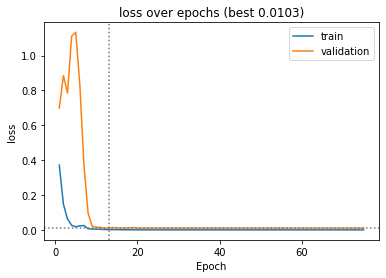

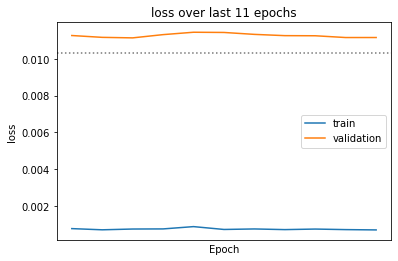

In [24]:
pretty_plot(history, 'loss')

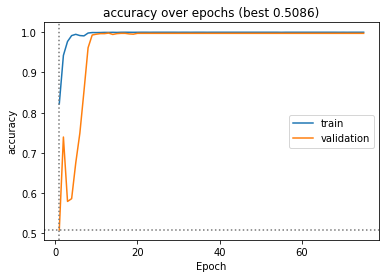

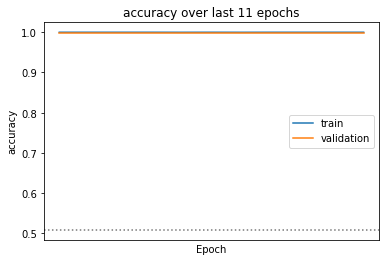

In [25]:
pretty_plot(history, 'accuracy')

In [26]:
resnet_model.load_weights('ptbd_weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

46/46 [==============================] - 0s 7ms/step - loss: 0.0171 - accuracy: 0.9952


[0.017123641446232796, 0.995192289352417]

46/46 [==============================] - 1s 4ms/step
Confusion matrix, without normalization
[[ 422    6]
 [   1 1027]]


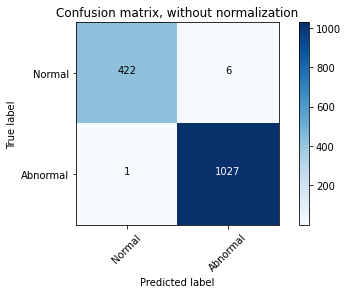

In [27]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")

cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH

In [28]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


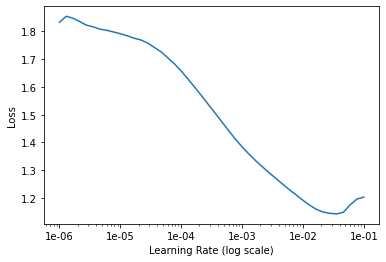

In [29]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-6, end_lr= 1e-01, max_steps=45, smoothing=0.6)
model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [30]:
m_resnet_model = get_resnet_model(5)
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: 1 / (2.0 ** (x - 1)))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
save_weights = ModelCheckpoint(filepath="mit_weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_weights])

Epoch 1/50
616/616 [==============================] - 18s 22ms/step - loss: 0.2003 - accuracy: 0.9404 - val_loss: 0.2228 - val_accuracy: 0.9427
Epoch 2/50
616/616 [==============================] - 12s 20ms/step - loss: 0.0755 - accuracy: 0.9789 - val_loss: 0.0707 - val_accuracy: 0.9792
Epoch 3/50
616/616 [==============================] - 12s 20ms/step - loss: 0.0599 - accuracy: 0.9832 - val_loss: 0.0612 - val_accuracy: 0.9818
Epoch 4/50
616/616 [==============================] - 12s 20ms/step - loss: 0.0528 - accuracy: 0.9853 - val_loss: 0.0598 - val_accuracy: 0.9824
Epoch 5/50
616/616 [==============================] - 13s 21ms/step - loss: 0.0489 - accuracy: 0.9862 - val_loss: 0.0582 - val_accuracy: 0.9828
Epoch 6/50
616/616 [==============================] - 13s 21ms/step - loss: 0.0469 - accuracy: 0.9864 - val_loss: 0.0572 - val_accuracy: 0.9828
Epoch 7/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0455 - accuracy: 0.9868 - val_loss: 0.0569 - val_accuracy:

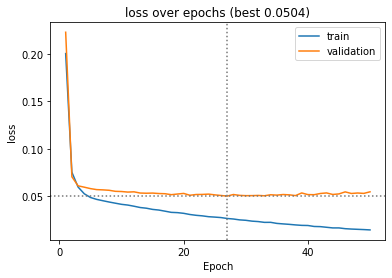

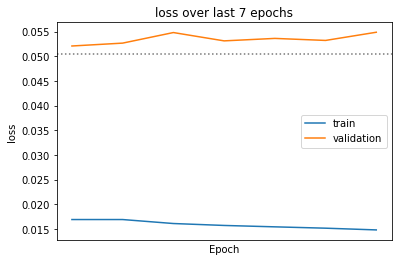

In [32]:
pretty_plot(history, 'loss')

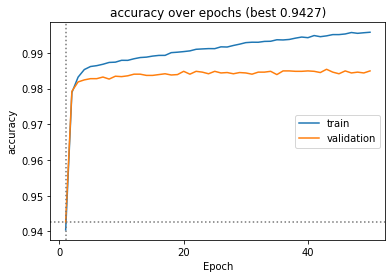

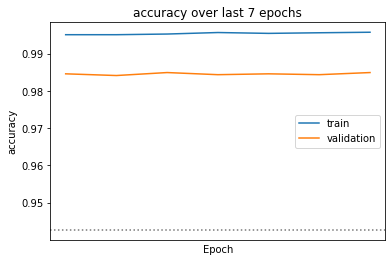

In [33]:
pretty_plot(history, 'accuracy')

In [34]:
m_resnet_model.load_weights('mit_weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 4s 5ms/step - loss: 0.0609 - accuracy: 0.9835


685/685 [==============================] - 3s 4ms/step
Confusion matrix, without normalization
[[18031    45    23     8    11]
 [  126   420    10     0     0]
 [   44     4  1377    18     5]
 [   24     0    18   120     0]
 [   19     1     5     0  1583]]


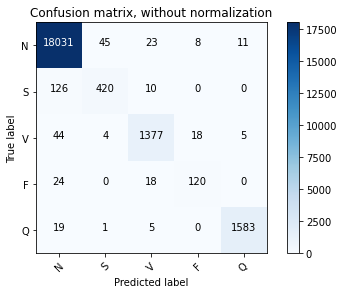

In [35]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

In [36]:
m_resnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_101 (Conv1D)            (None, 183, 32)      192         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_101 (Batch  (None, 183, 32)     128         ['conv1d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_99 (ReLU)                (None, 183, 32)      0           ['batch_normalization_101[0

In [37]:
resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_67 (Conv1D)             (None, 183, 32)      192         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_67 (BatchN  (None, 183, 32)     128         ['conv1d_67[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_65 (ReLU)                (None, 183, 32)      0           ['batch_normalization_67[0]

In [38]:
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(64, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_101 (Conv1D)            (None, 183, 32)      192         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_101 (Batch  (None, 183, 32)     128         ['conv1d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_99 (ReLU)                (None, 183, 32)      0           ['batch_normalization_101[0

In [39]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(m_resnet_model)

save_best_weights = ModelCheckpoint(filepath="t_weights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                             shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


91/91 [==============================] - 3s 15ms/step - loss: 0.3194 - accuracy: 0.8620 - val_loss: 0.2027 - val_accuracy: 0.9113
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 0.1673 - accuracy: 0.9314 - val_loss: 0.1534 - val_accuracy: 0.9409
Epoch 3/100
91/91 [==============================] - 1s 8ms/step - loss: 0.1219 - accuracy: 0.9546 - val_loss: 0.1095 - val_accuracy: 0.9608
Epoch 4/100
91/91 [==============================] - 1s 10ms/step - loss: 0.0964 - accuracy: 0.9656 - val_loss: 0.0826 - val_accuracy: 0.9698
Epoch 5/100
91/91 [==============================] - 1s 11ms/step - loss: 0.0739 - accuracy: 0.9740 - val_loss: 0.0534 - val_accuracy: 0.9849
Epoch 6/100
91/91 [==============================] - 1s 9ms/step - loss: 0.0646 - accuracy: 0.9779 - val_loss: 0.0586 - val_accuracy: 0.9814
Epoch 7/100
91/91 [==============================] - 1s 7ms/step - loss: 0.0595 - accuracy: 0.9796 - val_loss: 0.0604 - val_accuracy: 0.9753
Epoch 8/100
91/91 [===

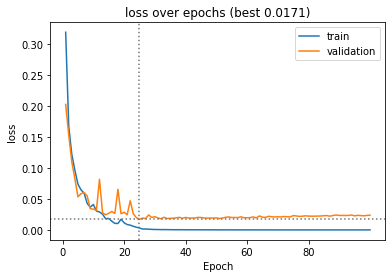

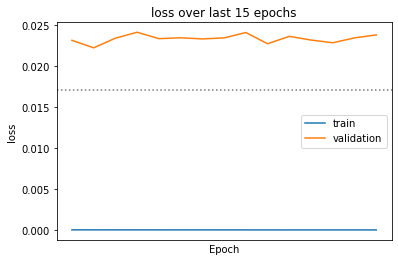

In [40]:
pretty_plot(history, 'loss')

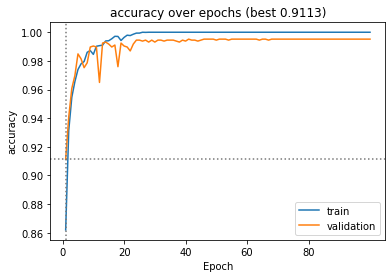

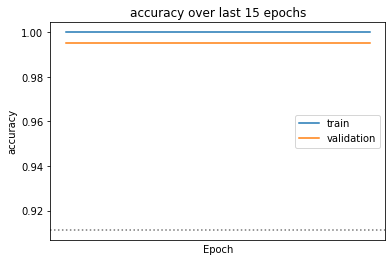

In [41]:
pretty_plot(history, 'accuracy')

In [42]:
transfer_model.load_weights('t_weights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test)

46/46 [==============================] - 1s 6ms/step - loss: 0.0614 - accuracy: 0.9837


[0.061368659138679504, 0.9836956262588501]

46/46 [==============================] - 1s 4ms/step
Confusion matrix, without normalization
[[ 416   12]
 [  11 1017]]


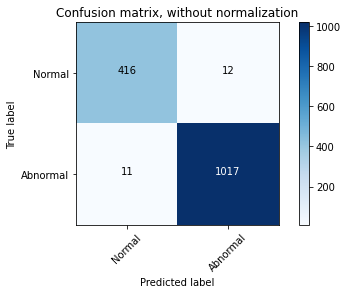

In [43]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")

cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

In [44]:

def get_transfer_model2(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(64, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(5, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model2(m_resnet_model).summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_101 (Conv1D)            (None, 183, 32)      192         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_101 (Batch  (None, 183, 32)     128         ['conv1d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_99 (ReLU)                (None, 183, 32)      0           ['batch_normalization_101[0

In [45]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model2(resnet_model)

save_best_weights = ModelCheckpoint(filepath="t2_weights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


616/616 [==============================] - 7s 8ms/step - loss: 0.1795 - accuracy: 0.9519 - val_loss: 0.1468 - val_accuracy: 0.9601
Epoch 2/100
616/616 [==============================] - 4s 7ms/step - loss: 0.1073 - accuracy: 0.9696 - val_loss: 0.1094 - val_accuracy: 0.9711
Epoch 3/100
616/616 [==============================] - 4s 7ms/step - loss: 0.0920 - accuracy: 0.9739 - val_loss: 0.1110 - val_accuracy: 0.9698
Epoch 4/100
616/616 [==============================] - 4s 7ms/step - loss: 0.0821 - accuracy: 0.9762 - val_loss: 0.0892 - val_accuracy: 0.9762
Epoch 5/100
616/616 [==============================] - 4s 7ms/step - loss: 0.0748 - accuracy: 0.9782 - val_loss: 0.1030 - val_accuracy: 0.9729
Epoch 6/100
616/616 [==============================] - 4s 7ms/step - loss: 0.0694 - accuracy: 0.9793 - val_loss: 0.0866 - val_accuracy: 0.9760
Epoch 7/100
616/616 [==============================] - 4s 7ms/step - loss: 0.0660 - accuracy: 0.9804 - val_loss: 0.0878 - val_accuracy: 0.9785
Epoch 8/100

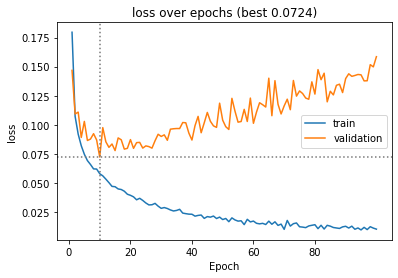

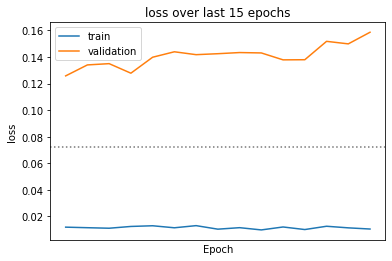

In [47]:
pretty_plot(history, 'loss')

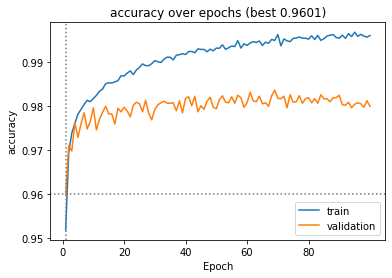

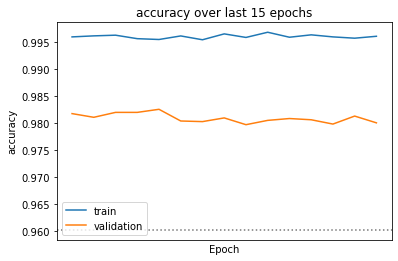

In [48]:
pretty_plot(history, 'accuracy')

In [49]:
transfer_model.load_weights('t2_weights.hdf5')
X_mitbih_test = transfer_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 4s 5ms/step - loss: 0.0787 - accuracy: 0.9792


685/685 [==============================] - 3s 5ms/step
Confusion matrix, without normalization
[[18031    45    23     8    11]
 [  126   420    10     0     0]
 [   44     4  1377    18     5]
 [   24     0    18   120     0]
 [   19     1     5     0  1583]]


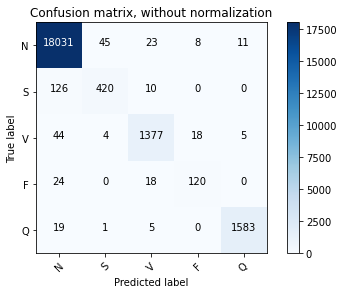

In [50]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')